In [1]:
import graph_tool.all as gt
from math import sqrt

In [2]:
from random import *

In [3]:
from libs.community_detection.o import *

In [4]:
csvGraphsPath="../graphs/csv/"
csvGraphFileName="facebook_combined.csv"
csvGraphFilePath=csvGraphsPath+csvGraphFileName
formatedGraphPath="../graphs/formatted/"
fbGraph=gt.load_graph_from_csv(csvGraphFilePath)

In [5]:
import igraph as ig

In [6]:
F=ig.Graph.Read("../graphs/formatted/facebook_combined.csv",format="ncol").as_undirected()

In [7]:
nbWorkers=100

In [8]:
%time workerIds,partition,clusterGraph,clusterIds=assignWorkers(F,nbWorkers)
print(workerIds)

igraph.Vertex(<igraph.Graph object at 0x7f5b598079a0>, 350, {'name': 'V2740', 'color': (1, 0.0, 0.0), 'cluster': 0})
CPU times: user 24.3 ms, sys: 286 µs, total: 24.5 ms
Wall time: 24.3 ms
igraph.Vertex(<igraph.Graph object at 0x7f5b598079a0>, 430, {'name': 'V1967', 'color': (1, 0.0, 0.4615384615384617), 'cluster': 1})
CPU times: user 37.2 ms, sys: 0 ns, total: 37.2 ms
Wall time: 36.8 ms
igraph.Vertex(<igraph.Graph object at 0x7f5b598079a0>, 434, {'name': 'V1911', 'color': (1, 0.46153846153846156, 0.0), 'cluster': 2})
CPU times: user 53.2 ms, sys: 0 ns, total: 53.2 ms
Wall time: 52.6 ms
igraph.Vertex(<igraph.Graph object at 0x7f5b598079a0>, 422, {'name': 'V2656', 'color': (1, 0.0, 0.9230769230769234), 'cluster': 3})
CPU times: user 40.2 ms, sys: 0 ns, total: 40.2 ms
Wall time: 39.9 ms
igraph.Vertex(<igraph.Graph object at 0x7f5b598079a0>, 542, {'name': 'V3434', 'color': (1, 0.9230769230769231, 0.0), 'cluster': 4})
CPU times: user 52.7 ms, sys: 0 ns, total: 52.7 ms
Wall time: 52.3 ms
ig

### What if we distantiated workers based on the whole graph (as if one unique community)

%time workerIds=F.vs[maxShortestPathNodesSelection(F,nbWorkers)]["name"]

### Arbitrary workers

In [9]:
workerIds=['V2927', 'V2962', 'V1546', 'V2358', 'V1924', 'V1190', 'V2638', 'V3183', 'V4017', 'V2861', 'V1579', 'V609', 'V23', 'V3605', 'V3810', 'V3429', 'V3606', 'V2070', 'V1077', 'V2216', 'V189', 'V696', 'V2806', 'V182', 'V1878', 'V1109', 'V3435', 'V2700', 'V3997', 'V1764', 'V3486', 'V3953', 'V2444', 'V98', 'V2808', 'V1530', 'V256', 'V3033', 'V185', 'V588', 'V39', 'V1558', 'V2507', 'V1728', 'V1328', 'V181', 'V2701', 'V3660', 'V985', 'V3315', 'V399', 'V400', 'V1410', 'V126', 'V1444', 'V667', 'V2672', 'V2368', 'V197', 'V3974', 'V1586', 'V3424', 'V1726', 'V1066', 'V1561', 'V3054', 'V2582', 'V3897', 'V3386', 'V1114', 'V593', 'V447', 'V1182', 'V2760', 'V2654', 'V2033', 'V683', 'V878', 'V281', 'V2052', 'V2804', 'V840', 'V2130', 'V1469', 'V2148', 'V3745', 'V3093', 'V4004', 'V431', 'V572', 'V3539', 'V935', 'V3970', 'V2704', 'V3996', 'V762', 'V1349', 'V1927', 'V454', 'V3643']

## Plot

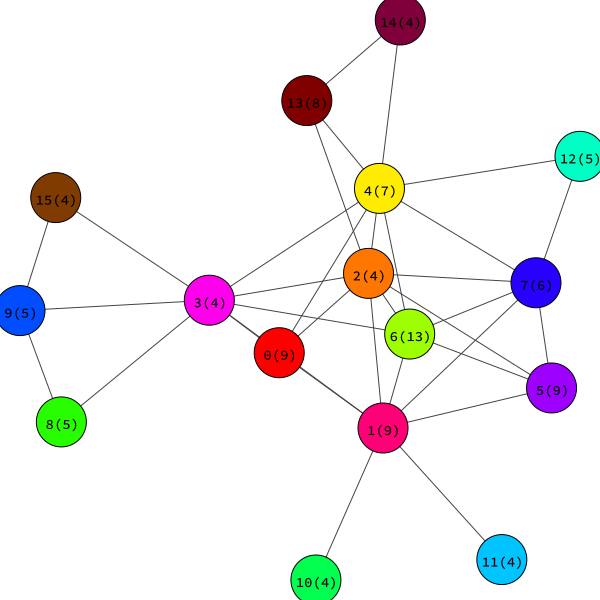

In [10]:
for idx, cluster in enumerate(clusterGraph.vs):
    if cluster.index in clusterIds:
        cluster["size"]=50
    cluster["color"]=partition.subgraph(idx).vs[0]["color"]
    cluster["label"]="{}({})".format(idx,cluster["nb_workers"])
ig.plot(clusterGraph)

In [11]:
for v in F.vs:
    if v["name"] in workerIds:
        v["size"]=25
        v["shape"]="triangle"
    else:
        v["size"]=1
        v["shape"]="circle"

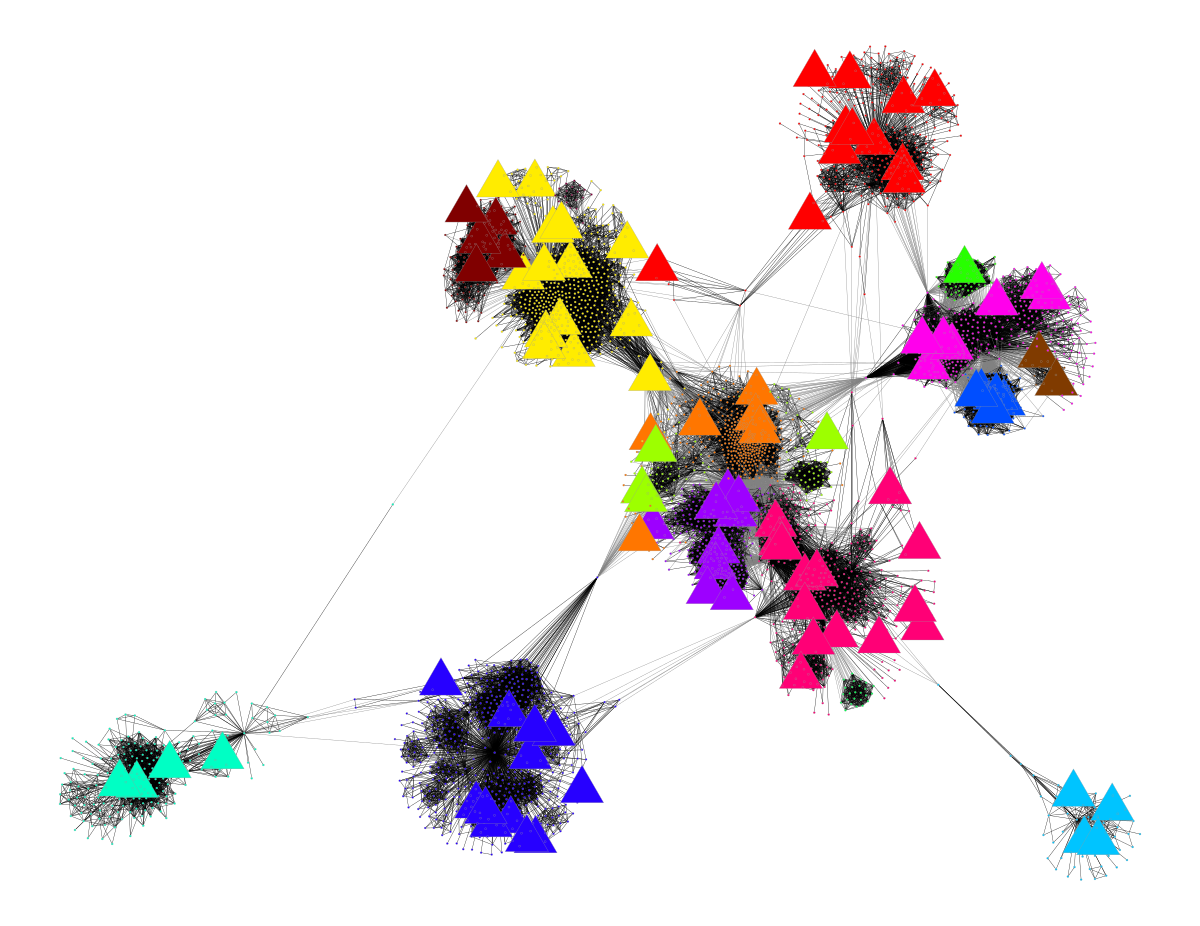

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5b58b40fd0, at 0x7f5b58b40f70>

In [12]:
G=F.to_graph_tool(vertex_attributes={"color":"vector<float>","size":"int","shape":"string"},edge_attributes={"color":"vector<float>"})
gt.graph_draw(G, vertex_fill_color=G.vertex_properties["color"],vertex_shape=G.vertex_properties["shape"],vertex_size=G.vertex_properties["size"],edge_color=G.edge_properties["color"])

## Evaluate

Same Counter({2: 688, 3: 110, 1: 62})
Other Counter({4: 3500, 3: 2422, 5: 1644, 2: 778, 6: 564, 7: 116, 8: 16})


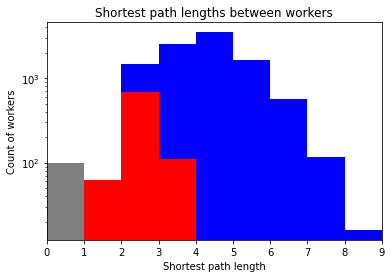

In [13]:
import numpy as np
from matplotlib import pyplot as plt

data=list(graphDistances(F,workerIds))
maxDist=max([max(l,default=0) for l in data],default=0)
colors=["grey","red","blue"]
labels=["self","same community","other community"]
# fixed bin size
bins = np.arange(0, 100, 1) # fixed bin size

plt.xlim([0, maxDist+1])
plt.yscale("log")
plt.hist(data, bins=bins, color=colors, label=labels, stacked=True)
plt.title('Shortest path lengths between workers')
plt.xlabel('Shortest path length')
plt.ylabel('Count of workers')

plt.show()

In [14]:
#the greater the value, the better
print(sum([sum(l) for l in data]))

37134


### Intra cluster distances

Same Counter({2: 110, 3: 20, 1: 2})
Other Counter({4: 493, 3: 305, 5: 148, 6: 70, 7: 20, 2: 20})
Same Counter({2: 88, 3: 86, 1: 8})
Other Counter({4: 618, 3: 442, 2: 68, 5: 52, 6: 24})
Same Counter({2: 30})
Other Counter({3: 287, 4: 116, 2: 113, 5: 36, 6: 12})
Same Counter({2: 34, 1: 8})
Other Counter({4: 316, 3: 131, 5: 112, 2: 64, 7: 14, 6: 14})
Same Counter({2: 178, 1: 4})
Other Counter({4: 519, 3: 322, 5: 188, 2: 123, 6: 52})
Same Counter({2: 68, 1: 4})
Other Counter({3: 417, 4: 200, 2: 134, 5: 50, 6: 18})
Same Counter({2: 10, 1: 2})
Other Counter({3: 208, 2: 76, 4: 72, 5: 24, 6: 4})
Same Counter({2: 128, 1: 4})
Other Counter({5: 552, 4: 384, 3: 72, 6: 48})
Same Counter()
Other Counter({4: 56, 5: 16, 2: 14, 3: 9, 7: 2, 6: 2})
Same Counter({1: 16, 2: 4})
Other Counter({4: 280, 5: 80, 2: 50, 3: 45, 7: 10, 6: 10})
Same Counter()
Other Counter()
Same Counter({2: 12})
Other Counter({6: 172, 5: 160, 4: 32, 8: 8, 7: 8, 3: 4})
Same Counter({2: 6, 3: 4, 1: 2})
Other Counter({5: 110, 6: 110,

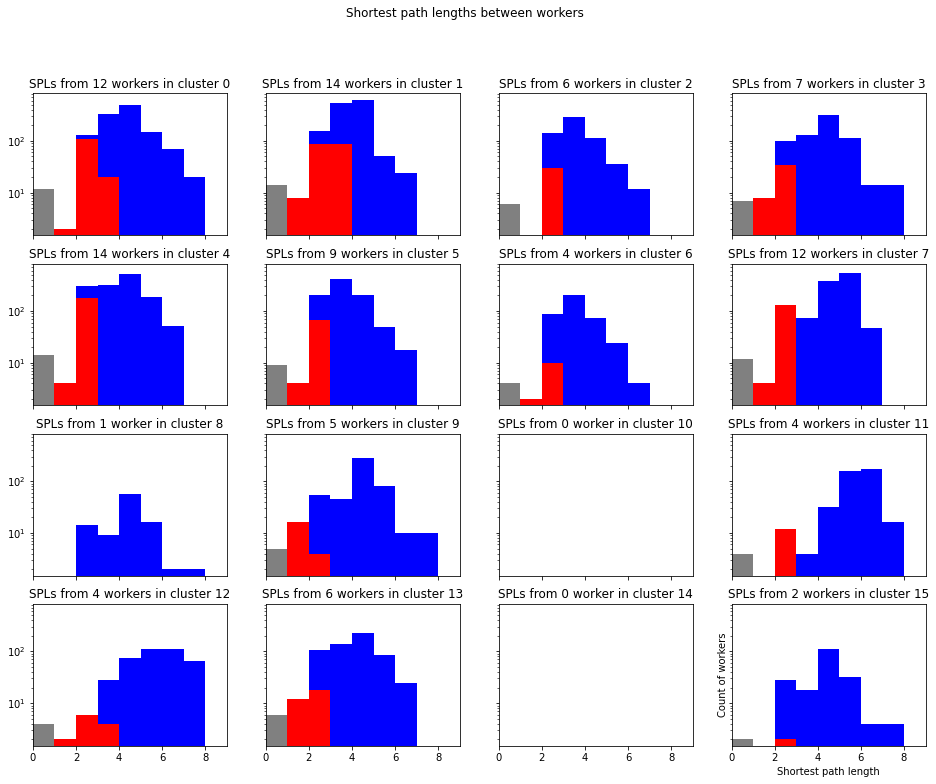

In [15]:
import numpy as np
from matplotlib import pyplot as plt

nbClusters=len(partition.subgraphs())
nbCol=4
fig,ax = plt.subplots(nrows = nbClusters//nbCol, ncols = nbCol,sharex=True, sharey=True,figsize=(nbCol*4,3*nbClusters//nbCol))

for idx, subgraph in enumerate(partition.subgraphs()):
    inClusterWorkers=[w for w in workerIds if w in subgraph.vs["name"]]
    data=list(graphDistances(F,inClusterWorkers,workerIds,subgraph.vs[0]["cluster"]))
    colors=["grey","red","blue"]
    labels=["self","same community","other community"]

    # fixed bin size
    bins = np.arange(0, maxDist+1, 1) # fixed bin size

    ax[idx//nbCol][idx%nbCol].hist(data, bins=bins, color=colors, label=labels, stacked=True)
    ax[idx//nbCol][idx%nbCol].title.set_text('SPLs from {} worker{} in cluster {}'.format(len(inClusterWorkers),"s" if len(inClusterWorkers)>1 else "",idx))
plt.xlim([0, maxDist+1])
plt.yscale("log")
plt.suptitle('Shortest path lengths between workers')
plt.xlabel('Shortest path length')
plt.ylabel('Count of workers')
plt.show()

## Graph Metrics

### Max distance between nodes (graph diameter)

In [16]:
print(F.diameter())

8


### Distances inter-nodes intra-clusters (cluster diameters)

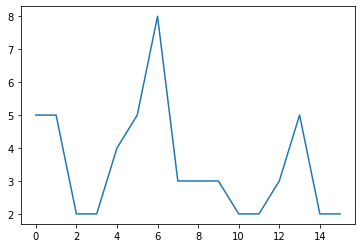

In [17]:
subgraphs=partition.subgraphs()
diameters=list([subgraph.diameter() for subgraph in subgraphs])
plt.plot(diameters)

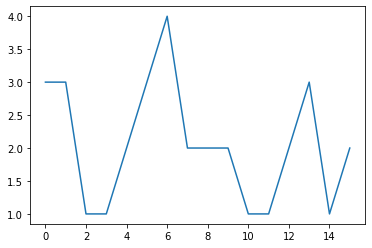

In [18]:
radii=list([subgraph.radius() for subgraph in subgraphs])
plt.plot(radii)

### Nodes per community

In [19]:
from collections import Counter
nbClusters=len(Counter(F.vs["cluster"]))

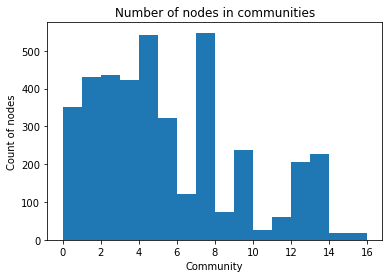

In [20]:
bins = np.arange(0, nbClusters+1, 1)
plt.hist(F.vs["cluster"], bins=bins)
plt.title('Number of nodes in communities')
plt.xlabel('Community')
plt.ylabel('Count of nodes')

plt.show()

### Workers per cluster

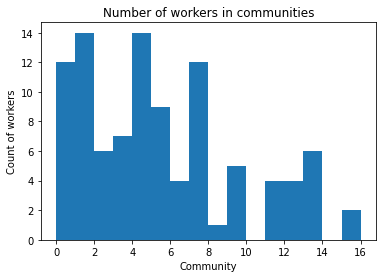

In [21]:
data=[F.vs.find(worker)["cluster"] for worker in workerIds]
bins = np.arange(0, nbClusters+1, 1)
plt.hist(data, bins=bins)
plt.title('Number of workers in communities')
plt.xlabel('Community')
plt.ylabel('Count of workers')

plt.show()

### Cluster diameter based worker count

In [22]:
diameters=[subgraph.diameter() for subgraph in partition.subgraphs()]

workers=[diameter//2+diameter%2 for diameter in diameters]
assignedWorkers=sum(workers)
print(assignedWorkers)

32
